In [1]:
# Going to be taking the data for yearly stats from basketball reference.com
import requests
from bs4 import BeautifulSoup
years_to_grab = range(2010,2019)

html_format = 'https://www.basketball-reference.com/leagues/NBA_2012_per_game.html'

# iterate through each year
all_soups = {}
for curr_year in years_to_grab:
    # to iterate through each year just replace the year from above
    curr_html = html_format.replace("2012", str(curr_year))
    # get data from proper page  and store in all_soups
    page = requests.get(curr_html)
    all_soups[str(curr_year)] = BeautifulSoup(page.text,'lxml')

In [7]:
# For each year lets extract the data and respective headers
all_data = {}
all_headers = {}
for curr_year in years_to_grab:
    data = []
    headers = []
    table = all_soups[str(curr_year)].find('table')
    table_body = table.find('tbody')
    rows = table_body.find_all('tr')
    nRows = len(rows)
    print(nRows)

    # to actually extract the data for each year
    for curr_row in rows:
        all_col_that_row = curr_row.find_all('td')
        if len(all_col_that_row) > 0:
            data_curr_row = []
            for curr_col in all_col_that_row:
                # if isnumeric convert to float for later math
                if isfloat(curr_col.text):
                    data_curr_row.append(float(curr_col.text))
                else:
                    data_curr_row.append(curr_col.text)      
            data.append(data_curr_row)
    # now lets save
    all_data[str(curr_year)] = data
    

    # lets also get the header information so can index into each category quickly
    table_head = table.find('thead')
    table_head_row = table_head.find('tr')
    th_col = table_head_row.find_all('th')
    for curr_head in th_col:
        headers.append(curr_head.text)

    # have to remove first value or headers bc rank isn't an actual value in data scraped
    headers.remove('Rk')
    all_headers[str(curr_year)] = headers


600
647
574
596
635
675
601
619
690


In [24]:
# all helper functions for this script
import numpy as np
from IPython.core.debugger import set_trace

# quickly test if value is a float
def isfloat(value):
  try:
    float(value)
    return True
  except ValueError:
    return False

# make a function that quickly will give you all values in a column that you care about
# assumes that the length of the headers label matches the number of columns in the dataset
def get_stats_player(dataset,headers,year,stat="all",name="all",pos='all'):
    if isinstance(year,str):
        curr_data = dataset[year]
        curr_headers = headers[year]
    else:
        curr_data = dataset[str(year)]
        curr_headers = headers[str(year)]
    # if want all stats see what that should be
    if stat == "all":
        stat = [curr_headers[i] for i in range(0,len(curr_data[0])) if isfloat(curr_data[0][i])]
    # check if type of data is a list and if not make it one
    if isinstance(stat, list) == False:
        stat = [stat]
    # these are the columns to use based off the stats selected
    col_to_use = []
    for curr_category in stat:
        col_to_use.append(curr_headers.index(curr_category))
    # for indexing purposes lets grab all of the names and all of the positions
    all_names =[]
    all_pos = []
    all_teams = []
    for curr_row in range(0,np.shape(curr_data)[0]):
        # get all the names
        all_names.append(curr_data[curr_row][curr_headers.index("Player")])
        # get all the positions
        all_pos.append(curr_data[curr_row][curr_headers.index("Pos")])
        all_teams.append(curr_data[curr_row][curr_headers.index("Tm")])
    # if gave stat as player or pos then just give this vector output
    # weird way to use the function and not recommended
    if stat == ['Player']:
        final_output = [all_names]
        return final_output
    elif stat == ['Pos']:
        final_output = [all_pos]
        return final_output
    elif stat == ['Tm']:
        final_output = [all_teams]
        return final_output
    # now grab that col of the dataset for those players you want
    data_for_relevant_col = []
    for curr_col in col_to_use:
        curr_vec = []
        for curr_row in range(0,np.shape(curr_data)[0]):
            #dealing with empty data bc didn't attempt something so making 0 if empty
            if isfloat(curr_data[curr_row][curr_col]):
                curr_vec.append(curr_data[curr_row][curr_col])
            else:
                curr_vec.append(0)
        data_for_relevant_col.append(curr_vec)
    # assuming you will either sort by name or position
    if name!= "all":
        final_output = []
        for curr_cat in range(0,np.shape(data_for_relevant_col)[0]):
            final_output.append(data_for_relevant_col[curr_cat][all_names.index(name)])
    elif pos!= "all":
        # this is the index of all rows with this position
        idx = [curr_pos for curr_pos in range(0,len(all_pos)) if pos in all_pos[curr_pos]]
        final_output = []
        for curr_cat in range(0,np.shape(data_for_relevant_col)[0]):
            for curr_idx in idx:
                final_output.append(data_for_relevant_col[curr_cat][curr_idx]) 
    else:
        final_output = data_for_relevant_col
    return final_output


In [15]:
# test = get_stats_player(all_data,all_headers,2018,stat="all",name="Alex Abrines")
# test = get_stats_player(all_data,all_headers,2018,stat="3P%",pos="PF")
# test2 = get_stats_player(all_data,all_headers,2018,stat="PS/G",pos="PF")
test = get_stats_player(all_data,all_headers,2018,stat="Player")
print(headers)
print(len(test))


['Player', 'Pos', 'Age', 'Tm', 'G', 'GS', 'MP', 'FG', 'FGA', 'FG%', '3P', '3PA', '3P%', '2P', '2PA', '2P%', 'eFG%', 'FT', 'FTA', 'FT%', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PS/G']
664


In [23]:
# for saving
import json
  
json = json.dumps(all_data)
f = open("/Users/rohanramesh/Documents/SportsData/NBA/YearlyData.json","w")
f.write(json)
f.close()

(664, 29)
29


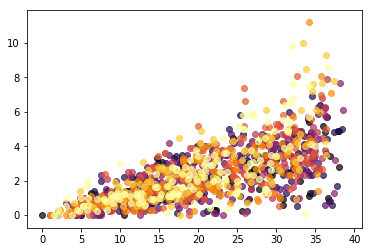

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline
import time
cm = plt.get_cmap('inferno',len(range(2010,2019)))
print(np.shape(all_data['2018']))
print(len(headers))
idx = 0
for curr_year in range(2010,2019):
    curr_stat = get_stats_player(all_data,all_headers,curr_year,stat="3PA",pos="PG")
    curr_stat2 = get_stats_player(all_data,all_headers,curr_year,stat="MP",pos="PG")
#     plt.hist(curr_stat,bins=20,color=cm.colors[idx])
    plt.scatter(curr_stat2,curr_stat,c=cm.colors[idx],alpha=0.7)
    idx+=1


plt.show()

In [31]:
import pandas as pd




yearly = pd.read_html(str(table))
curr_df = yearly[0]
# convert to numeric
curr_df.fillna(value=0)
curr_df = curr_df.apply(pd.to_numeric ,errors='ignore')
# print(curr_df.info())
# # diff ways to index in
# curr_df.loc[0:5]['Player']
# idx = curr_df.loc[:,'Pos']
# # print(get_stats_player(all_data,all_headers,curr_year,stat="MP",pos="PG")) 
# A = (curr_df.loc[idx=='PG','MP'])
# # # print(A.tolist())
A = curr_df.loc[:,'Rk'].values
# print(A)
# print(pd.to_numeric(curr_df.loc[idx=='PG','MP'].values))
# plt.plot(A)
# plt.show()
# plt.plot(get_stats_player(all_data,all_headers,curr_year,stat="MP",pos="PG"))
# plt.show()
# print(get_stats_player(all_data,all_headers,curr_year,stat="MP",pos="PG"))
# print(float(A.tolist()))
# print(get_stats_player(all_data,all_headers,curr_year,stat="MP",pos="PG"))
# # plt.scatter(curr_df.loc[idx=='PF','MP'],curr_df.loc[idx=='PF','3PA'])
# # plt.show()

In [30]:
import pandas as pd
# lets build the DataFrame - one for each year - had to do this way because of formatting of table
# first lets build giant dict with data from that year
All_df = {}
for curr_year in years_to_grab:
    curr_dict = {}
    for curr_header in headers:
        A = get_stats_player(all_data,all_headers,curr_year,stat=curr_header)
        curr_dict[curr_header] = A[0]
    curr_df = pd.DataFrame(data=curr_dict)
    All_df[str(curr_year)] = curr_df


(664, 29)
29


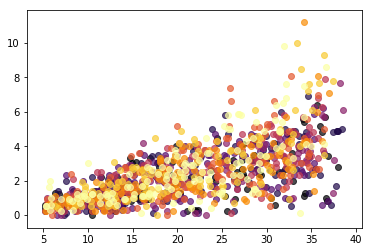

In [67]:
# plt.hist(All_df['2018'][['3PA']],bins=15)
cm = plt.get_cmap('inferno',len(range(2010,2019)))
print(np.shape(all_data['2018']))
print(len(headers))
cidx = 0
for curr_year in range(2010,2019):
    idx = (All_df[str(curr_year)]['Pos'] == 'PG') & (All_df[str(curr_year)]['MP'] > 5)
    curr_stat = All_df[str(curr_year)]['3PA'][idx]
    curr_stat2 = All_df[str(curr_year)]['MP'][idx]  
#     curr_stat = All_df[str(curr_year)].loc[idx,'3PA']
#     curr_stat2 = All_df[str(curr_year)].loc[idx,'MP']
#     plt.hist(curr_stat,bins=20,color=cm.colors[idx])
    plt.scatter(curr_stat2,curr_stat,c=cm.colors[cidx],alpha=0.7)
    cidx+=1
